# Experiment 1

A BiTCN Implementation that supports synthesized signals of arbitrary length and external datasets.



In [22]:
__author__ = "JUN WEI WANG"
__email__ = "wjw_03@outlook.com"

In [23]:
import torch
import numpy as np
import os
from os import path

import matplotlib.pyplot as plt
# from IPython.display import set_matplotlib_formats
# %matplotlib inline
# set_matplotlib_formats('svg')

# Check for CUDA!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently training on: {device}")

print("Your current working directory", os.getcwd())

Currently training on: cuda
Your current working directory C:\Users\wjw_0\dsp-project


# Base Parameters

In [ ]:
import src.generator.QAM as QAM

# MODE = "TRAINING"
MODE = "INFERENCE"
print(f"MODE: {MODE}")

DATASET_SOURCE = "394" # 实验数据序号 或者 SYNTH
# DATASET_SOURCE = "SYNTH"

SEED = 1
CONSTELLATION = "QAM"
QAM_ORDER = 64
NUMBEROFSYMBOLS = 51200
TAPS = 35

cons = QAM.read_constellation_file(QAM_ORDER, CONSTELLATION)

MODE: TRAINING


# Data Generator

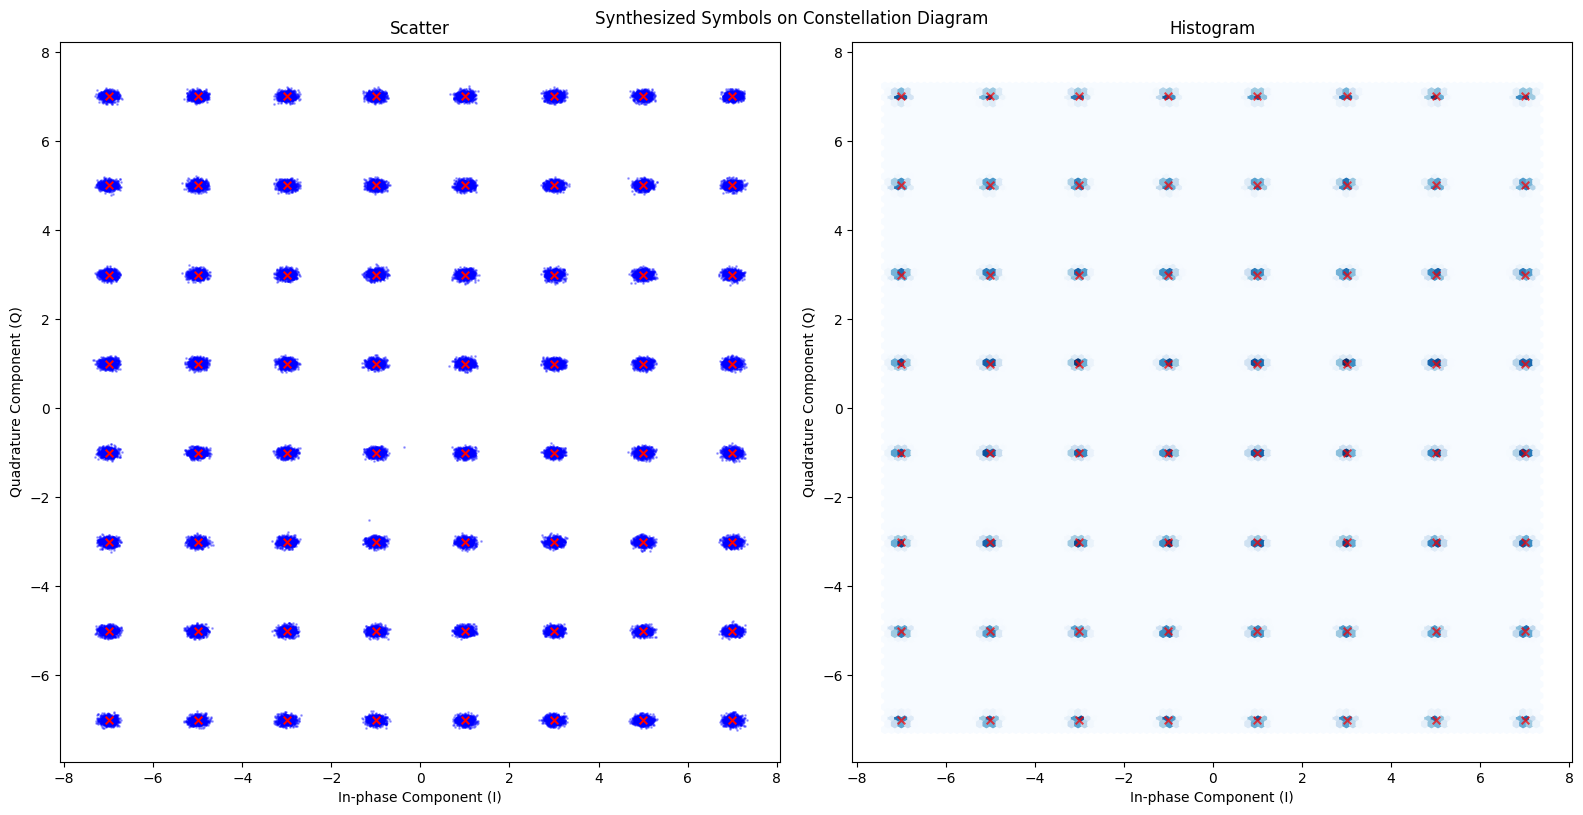

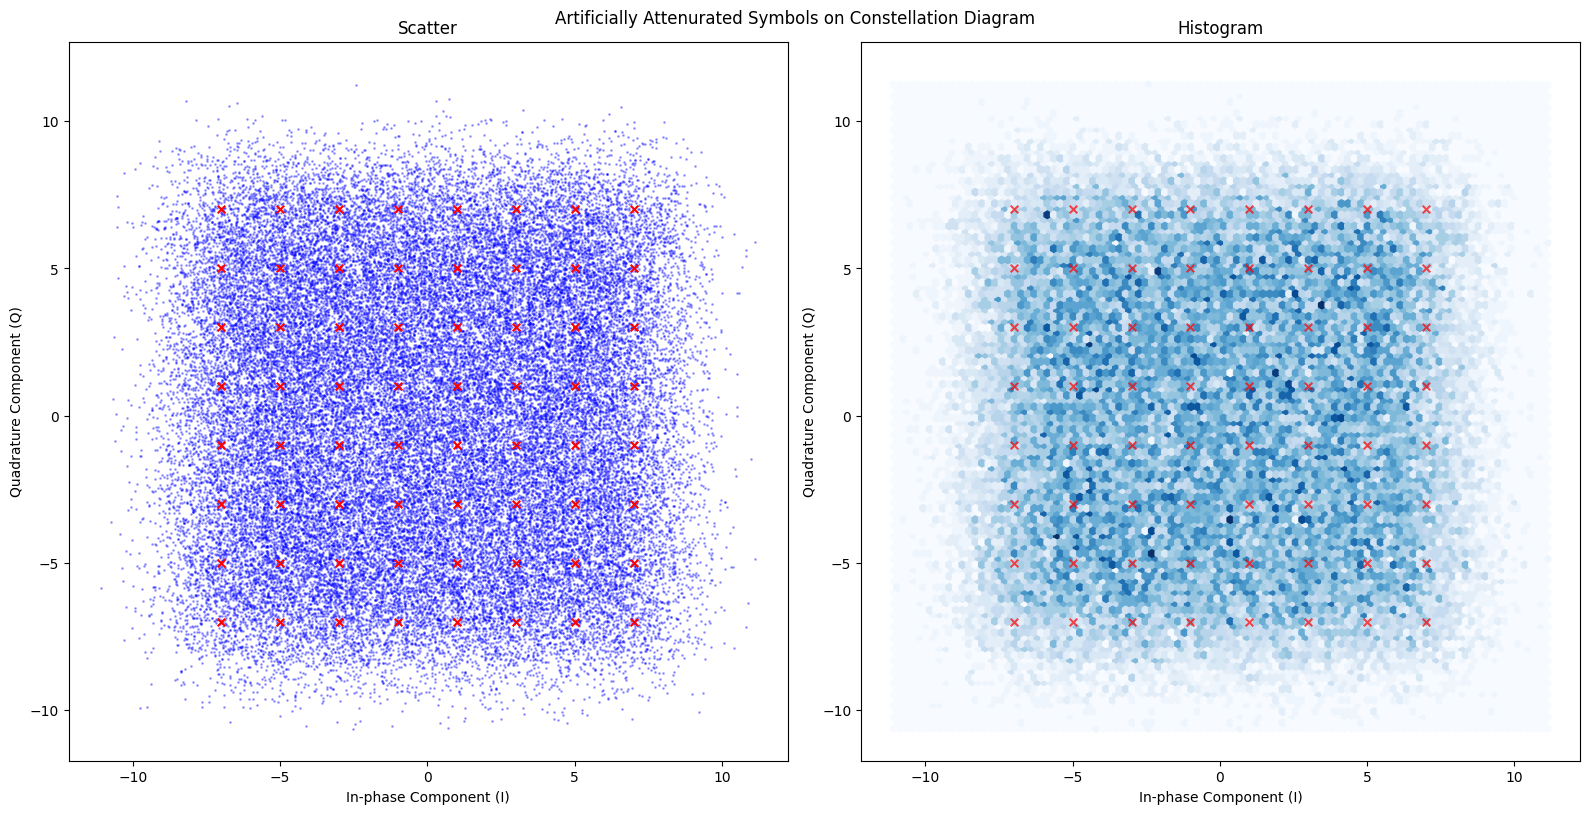

In [25]:
import src.generator.QAM as QAM

if DATASET_SOURCE == "SYNTH":
    attenurated_data, original_data, raw_data, QAM_bits, preamble_data, insertion_index = QAM.generate_seq(
        order=QAM_ORDER,
        cons=cons,
        num_symbols=NUMBEROFSYMBOLS,
        seed=SEED,
        taps=TAPS
    )

    og_demodulated_symbols, og_recoverdata = QAM.demodulation(
        original_data,
        NUMBEROFSYMBOLS,
        cons,
    )

    attenurated_data_demodulated_symbols, attenurated_data_recoverdata = QAM.demodulation(
        attenurated_data,
        NUMBEROFSYMBOLS,
        cons,
    )

    QAM.graph_IQ_constellation(
        "Synthesized Symbols",
        og_recoverdata,
        cons
    )

    QAM.graph_IQ_constellation(
        "Artificially Attenurated Symbols",
        attenurated_data_recoverdata,
        cons
    )


# Nerual Network

## Initialize Constants, Dataset, and the NN Model

In [26]:
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

# Neural Network
from src.nn.TCNN import BiTCN

# Dataset Tools
from torch.utils.data import DataLoader
from src.data.dataset import CustomDataset

In [27]:
# CONSTANTS
NN_MODEL = "BiTCN"
MODEL_EXT = "pth"
MODEL_FILENAME = f"{NN_MODEL}_best_{DATASET_SOURCE}.{MODEL_EXT}"

TRAIN_RATIO = 0.6

################################################################################
###########                      PARAMETERS                   ##################
################################################################################

BATCH_SIZE = 512 # used to be 512
WINDOW_SIZE = 256

# Trainning parameters
DROPOUT = 0.008
N_EPOCHS = 15
LEARNING_RATE = 3e-4

# Network parameters
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CHANNEL_SIZES = [32] * 5
KERNEL_SIZE = 16

## Load Dataset

In [28]:
DATASET_FOLDER = "dataset"

REAL_DATA_H = lambda x : f"data64QAM.txt"   # HOT-ENCODE
REAL_DATA = lambda x : f"OSC_sync_{x}.txt"
SYNTH_DATA = lambda x : f"SYNC_{x}.txt"
# NOTE: But for synthesized data, we can use our data generator implemented above

dataset: torch.utils.data.Dataset = None

try:
    if DATASET_SOURCE == "SYNTH":
        # Using synthesized data, no need to read any files
        try:
            attenurated_data
            original_data
        except:
            raise "Please run data generation"
        # print(attenurated_data.reshape(-1, 1))
        dataset = CustomDataset(None, win_len=WINDOW_SIZE)
        datas, labels = dataset.split_sequence(
            attenurated_data.reshape(-1, 1), 
            original_data.reshape(-1, 1), 
            WINDOW_SIZE
        )
        size = len(attenurated_data)
        dataset.dataset, dataset.labels, dataset.size = \
            torch.tensor(datas, dtype=torch.float32), \
            torch.tensor(labels, dtype=torch.float32), \
            size
        pass
    elif type(int(DATASET_SOURCE)) == int:
        # Read data from dataset
        dataset = CustomDataset(
            DATASET_FOLDER,
            REAL_DATA(int(DATASET_SOURCE)),
            REAL_DATA_H(-1),
            WINDOW_SIZE
        )
except ValueError:
    raise("Invalid target dataset")

print(f"{DATASET_SOURCE} dataset loaded")
print(f"Dataset length: {len(dataset)} | Size: {dataset.size}")

# Split into train and validation sets

train_size = int(TRAIN_RATIO * len(dataset))
print(f"Traning ratio (train:valid): {TRAIN_RATIO}:{1 - TRAIN_RATIO}")
print(f"Training size: {train_size} | Validation size: {len(dataset) - train_size}")
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

# Setup the training and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



SYNTH dataset loaded
Dataset length: 204545 | Size: 204800
Traning ratio (train:valid): 0.6:0.4
Training size: 122727 | Validation size: 81818


## Load Model

In [29]:
model: torch.nn.Module = None

model = BiTCN(
    INPUT_SIZE,
    OUTPUT_SIZE,
    CHANNEL_SIZES,
    KERNEL_SIZE,
    seq_len=WINDOW_SIZE,
    dropout=DROPOUT
)

print(f"{NN_MODEL} Model successfully Loaded")
model.to(device)

BiTCN Model successfully Loaded


BiTCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): ParametrizedConv1d(
          1, 32, kernel_size=(16,), stride=(1,), padding=(15,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (chomp1): Chomp1D()
        (relu1): PReLU(num_parameters=1)
        (dropout1): Dropout(p=0.008, inplace=False)
        (conv2): ParametrizedConv1d(
          32, 32, kernel_size=(16,), stride=(1,), padding=(15,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (chomp2): Chomp1D()
        (relu2): PReLU(num_parameters=1)
        (dropout2): Dropout(p=0.008, inplace=False)
        (net): Sequential(
          (0): ParametrizedConv1d(
            1, 32, kernel_size=(16,), stride=(1,), padding=(15,)
            (parametrizations): Modu

## Training

In [30]:
def train(model, device,train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        output = model(X_batch.to(device))
        loss = criterion(output, y_batch.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        average_loss = total_loss / len(train_loader)
    return average_loss

def validate(model, device, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc="Validation", leave=False):
            output = model(X_batch.to(device))
            loss = criterion(output, y_batch.to(device))
            total_loss += loss.item()
        average_loss = total_loss / len(val_loader)
    return average_loss

if MODE == "TRAINING":
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr = LEARNING_RATE
    )
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, alpha=0.99, eps=1e-8, weight_decay=0, momentum=0.8)
    scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

    # Train the model
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')

    for epoch in range(N_EPOCHS):
        print(f"Starting epoch {epoch + 1}/{N_EPOCHS}")

        train_loss = train(model, device, train_loader, optimizer, criterion)
        val_loss = validate(model, device, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        scheduler.step()

        print(f"Epoch [{epoch + 1}/{N_EPOCHS}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_FILENAME)
            print(f"Saved model with validation loss: {best_val_loss:.4f}")

Starting epoch 1/15


Epoch [1/15], Train Loss: 2.4511, Validation Loss: 0.1737
Saved model with validation loss: 0.1737
Starting epoch 2/15


Epoch [2/15], Train Loss: 0.1990, Validation Loss: 0.1500
Saved model with validation loss: 0.1500
Starting epoch 3/15


Epoch [3/15], Train Loss: 0.1784, Validation Loss: 0.1694
Starting epoch 4/15


Epoch [4/15], Train Loss: 0.1630, Validation Loss: 0.1406
Saved model with validation loss: 0.1406
Starting epoch 5/15


Epoch [5/15], Train Loss: 0.1601, Validation Loss: 0.1391
Saved model with validation loss: 0.1391
Starting epoch 6/15


Epoch [6/15], Train Loss: 0.1506, Validation Loss: 0.1707
Starting epoch 7/15


Epoch [7/15], Train Loss: 0.1463, Validation Loss: 0.1420
Starting epoch 8/15


KeyboardInterrupt: 

## Training Metrics

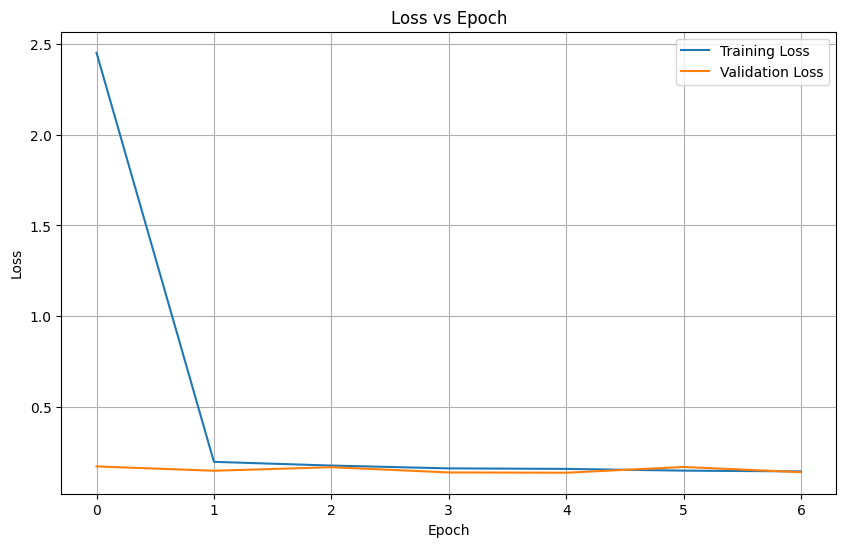

In [31]:
import matplotlib.pyplot as plt


# Plotting function
def plot_metrics(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

if MODE == "TRAINING":
    # Plot losses after training
    plot_metrics(train_losses, val_losses)

## Inference

In [32]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import math

from src.data.dataset import CustomDataset
from src.nn.TCNN import BiTCN

# Load the model
model = BiTCN(
    INPUT_SIZE,
    OUTPUT_SIZE,
    CHANNEL_SIZES,
    KERNEL_SIZE,
    seq_len=WINDOW_SIZE,
    dropout=DROPOUT
)
model = model.to(device)

model.load_state_dict(
    torch.load(MODEL_FILENAME, map_location=torch.device(device))
)

predictions = []

def inference(model, device, data_loader):
    model.eval()
    output=[]
    with torch.no_grad():
        import time
        for X_batch, y_batch in tqdm(data_loader, desc="Validation", leave=False):
            out = model(X_batch.to(device))
            output.append(out.detach().cpu())
            outputs = torch.cat(output, dim=0)
            outputs_np = outputs.numpy()
    return outputs_np.flatten()

data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

predictions = inference(model, device, data_loader)
half_window = math.floor((WINDOW_SIZE - 1) // 2)

og_data: np.ndarray = None

if DATASET_SOURCE == "SYNTH":
    og_data = original_data
else:
    hot_answer = path.join(os.getcwd(), "dataset", REAL_DATA_H(-1))
    with open(hot_answer, 'r') as file:
        og_data = np.array([float(line.strip()) for line in file.readlines()])

diff = dataset.size - (len(predictions)  + half_window*2)
prefix = og_data[:half_window + diff]
suffix = og_data[-half_window:]
final_predictions = np.concatenate([prefix.flatten(), predictions.flatten(), suffix.flatten()])
final_predictions = final_predictions.reshape(-1,1)
final_predictions = final_predictions.astype(np.float16)

np.savetxt(f"predition_{NN_MODEL}_{DATASET_SOURCE}.txt", final_predictions, delimiter="\n")

C:\Users\wjw_0\AppData\Local\Temp\ipykernel_32196\2347103781.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(MODEL_FILENAME, map_location=torch.device(device

# Post Processing

Demodulation & Visualization

In [35]:
cons = QAM.read_constellation_file(QAM_ORDER, CONSTELLATION)

demodulated_symbols, recoverdata = QAM.demodulation(
    final_predictions,
    NUMBEROFSYMBOLS,
    cons,
    taps=TAPS
)

if DATASET_SOURCE == "SYNTH":
    # Implementation Incomplete
    target = np.zeros(len(QAM_bits), dtype=int)
    for i, sample in enumerate(recoverdata):
        distances = np.abs(sample - cons)
        target[i] = np.argmin(distances)  # Find the nearest constellation point
    
    SER_res = QAM.calculate_ser(demodulated_symbols, target, TAPS)
    BER_res = QAM.calculate_ber(demodulated_symbols, target, TAPS, QAM_ORDER)
    print(f"SER (Symbol Error Rate): #wrong: {SER_res[0]}, rate:{SER_res[1]}")
    print(f"BER (Bit Error Rate):    #wrong: {BER_res[0]}, rate:{BER_res[1]}")
else:
    from src.visual.fft import fft, graph_log, graph_fft_overlap
    from src.data.file_handler import read_file
    from src.data.processing import parse_str
    
    ref_data = parse_str(read_file(path.join(DATASET_FOLDER, REAL_DATA_H(-1))))
    ref_data = torch.tensor(ref_data, dtype=torch.float32)
    ref_data = ref_data.reshape(1, -1).flatten()

    fft_signal_ref, freqs_ref = fft(ref_data)

    ref_symbols, ref_data = QAM.demodulation(
        ref_data,
        NUMBEROFSYMBOLS,
        cons
    )

    QAM.graph_IQ_constellation(
        "Reference Symbols",
        ref_data,
        cons
    )

    rx_data = parse_str(read_file(path.join(DATASET_FOLDER, REAL_DATA(DATASET_SOURCE))))
    rx_data = torch.tensor(rx_data, dtype=torch.float32)
    rx_data = rx_data.reshape(1, -1).flatten()

    fft_signal_rx, freqs_rx = fft(rx_data)

    rx_symbols, rx_data = QAM.demodulation(
        rx_data,
        NUMBEROFSYMBOLS,
        cons
    )

    QAM.graph_IQ_constellation(
        "Unprocessed RX Symbols",
        rx_data,
        cons
    )

    QAM.graph_IQ_constellation(
        "Post-Equalized RX Symbols",
        recoverdata,
        cons
    )

    graph_log(freqs_ref, fft_signal_ref, "Reference")
    graph_log(freqs_rx, fft_signal_rx, "Unprocessed RX")

    graph_fft_overlap(
        freqs_ref, fft_signal_ref,
        freqs_rx, fft_signal_rx,
        title="TX Signal vs Raw RX Signal",
        signal_1_name="TX",
        signal_2_name="RX"
    )

    fft_signal_pred, freqs_pred = fft(final_predictions.flatten())
    graph_fft_overlap(
        freqs_ref, fft_signal_ref,
        freqs_pred, fft_signal_pred,
        title="TX Signal vs Equalized Signal",
        signal_1_name="TX",
        signal_2_name="Equalized RX"
    )

    plt.show()

    SER_res = QAM.calculate_ser(demodulated_symbols, ref_symbols, TAPS)
    BER_res = QAM.calculate_ber(demodulated_symbols, ref_symbols, TAPS, QAM_ORDER)
    print(f"SER (Symbol Error Rate): #wrong: {SER_res[0]}, rate:{SER_res[1]}")
    print(f"BER (Bit Error Rate):    #wrong: {BER_res[0]}, rate:{BER_res[1]}")

SER (Symbol Error Rate): #wrong: 0, rate:0.0
BER (Bit Error Rate):    #wrong: 0, rate:0.0


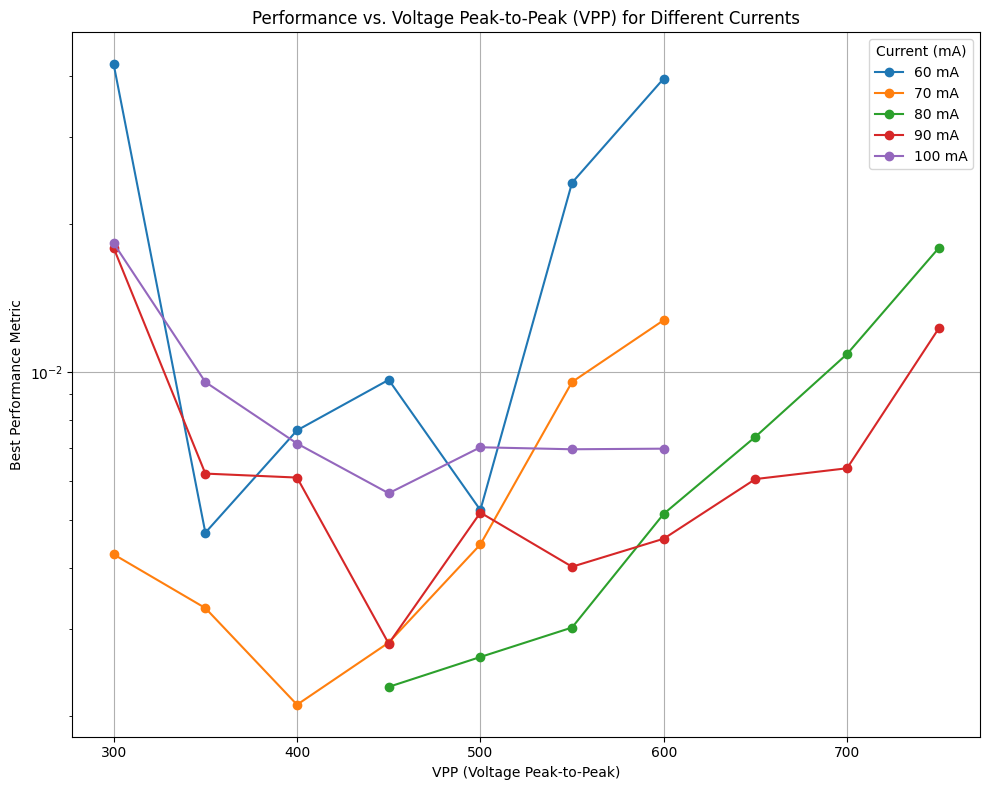

In [ ]:
import json
import matplotlib.pyplot as plt

file = path.join(DATASET_FOLDER, "tracker.json")

# Load data from the JSON file
with open(file, 'r') as file:
    data = json.load(file)["data"]

# Filter data for each current amplitude
currents = [60, 70, 80, 90, 100]
data_by_current = {I: [entry for entry in data if entry["I"] == I] for I in currents}

# Plot data for each current amplitude
plt.figure(figsize=(10, 8))

for I, entries in data_by_current.items():
    VPP = [entry["VPP"] for entry in entries]
    best = [entry["best"] for entry in entries]
    plt.plot(VPP, best, marker='o', linestyle='-', label=f'{I} mA')

plt.yscale("log")

# Customize the plot
plt.title("Performance vs. Voltage Peak-to-Peak (VPP) for Different Currents")
plt.xlabel("VPP (Voltage Peak-to-Peak)")
plt.ylabel("Best Performance Metric")
plt.grid(True)
plt.legend(title="Current (mA)")
plt.tight_layout()

# Show the plot
plt.show()
